In [19]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_mean_video
import pandas as pd
from natsort import natsorted
import time

In [26]:
eng = matlab.engine.start_matlab()
dir_ = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
videos = [(file, parse_mean_video(os.path.join(dir_, file))) for file in os.listdir(dir_) if (file != '.DS_Store' and '12.0hz' in file)]
frequency = 6
light_level = 0

In [27]:
print([(filename, video.shape) for (filename, video) in videos])

[('200FPS_12.0hz_1NDF.avi', (2005,)), ('200FPS_12.0hz_3NDF.avi', (2004,)), ('200FPS_12.0hz_0NDF.avi', (2005,)), ('200FPS_12.0hz_2NDF.avi', (2005,))]


In [30]:
to_plot = [(file, video) for (file, video) in videos if '0NDF' in file][0]

print(to_plot)


plt.plot(to_plot[1])
plt.title('Mean Frame Intensity')
plt.ylabel('Pixel Intensity')
plt.xlabel('Frame number')


('200FPS_12.0hz_0NDF.avi', array([122, 101,  84, ..., 135, 111,  92], dtype=uint8))


"\nplt.plot(to_plot[1])\nplt.title('Mean Frame Intensity')\nplt.ylabel('Pixel Intensity')\nplt.xlabel('Frame number')\n"

In [23]:
data_table = []
r2_table = []
for video_num, (filename, signal) in enumerate(videos):
    signal_mean = np.mean(signal)
    signal = (signal - signal_mean) / signal_mean

    signal_as_double: matlab.double = matlab.double(signal.astype(np.float64))
    frequency_as_double: matlab.double = matlab.double(frequency)

    data_row = []
    r2_row = [filename]
    for fps in (200, 200.4):
        observed_r2, observed_amplitude, observed_phase, observed_fit, observed_model_T, observed_signal_T = eng.fourierRegression(signal_as_double, frequency_as_double, matlab.double(fps), nargout=6)
        
        observed_fit = np.array(observed_fit).flatten()
        observed_model_T = np.array(observed_model_T).flatten()
        observed_signal_T = np.array(observed_signal_T).flatten()


        data_row.append([observed_signal_T, signal - np.mean(signal), observed_model_T, observed_fit])
        r2_row.append(observed_r2)

    data_table.append(data_row)
    r2_table.append(r2_row)


findings_df = pd.DataFrame(data=r2_table, columns=['video_name','200FPS', '200.4FPS'])

print(findings_df)


                        video_name    200FPS  200.4FPS
0   testFPS_6.0hz_3NDF_200FPS1.avi  0.981755  0.978495
1   testFPS_6.0hz_3NDF_200FPS3.avi  0.981835  0.978572
2   testFPS_6.0hz_3NDF_200FPS2.avi  0.976553  0.917275
3   testFPS_6.0hz_2NDF_200FPS2.avi  0.714524  0.547594
4   testFPS_6.0hz_2NDF_200FPS3.avi  0.817018  0.692299
5   testFPS_6.0hz_2NDF_200FPS1.avi  0.986362  0.983673
6   testFPS_6.0hz_0NDF_200FPS1.avi  0.912394  0.783369
7   testFPS_6.0hz_0NDF_200FPS2.avi  0.984412  0.981860
8   testFPS_6.0hz_0NDF_200FPS3.avi  0.982861  0.916882
9   testFPS_6.0hz_1NDF_200FPS3.avi  0.983559  0.980680
10  testFPS_6.0hz_1NDF_200FPS2.avi  0.983707  0.980067
11  testFPS_6.0hz_1NDF_200FPS1.avi  0.984458  0.981512


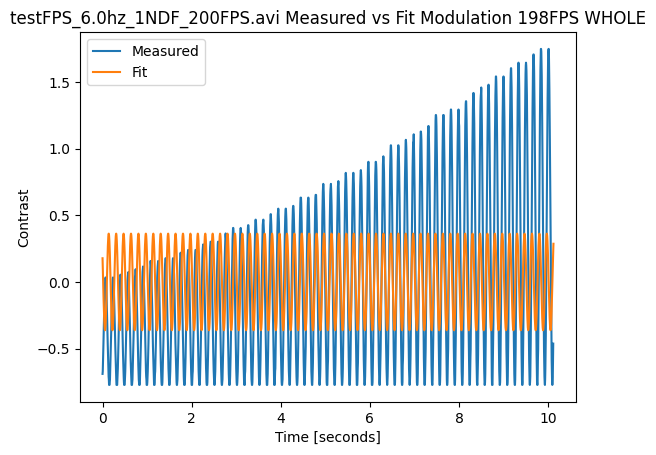

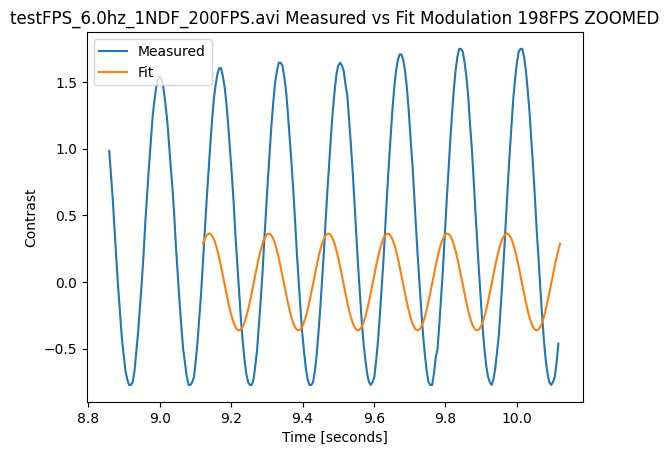

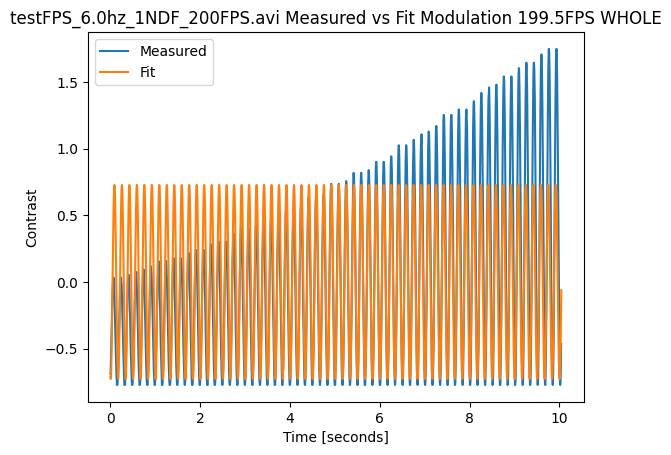

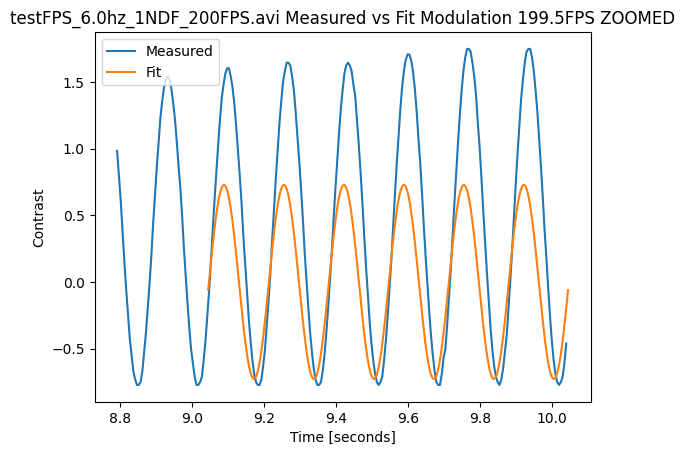

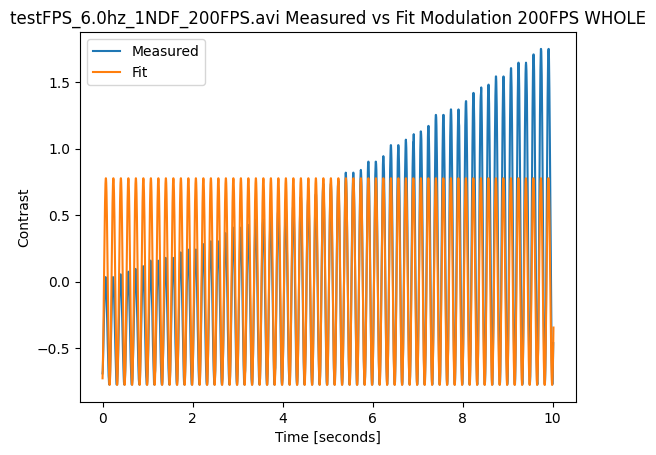

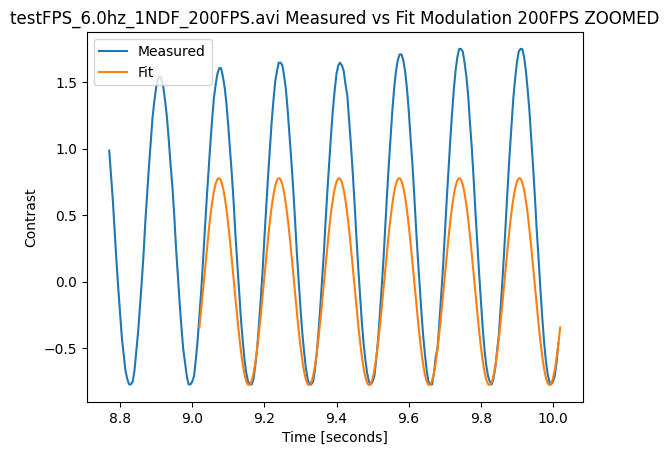

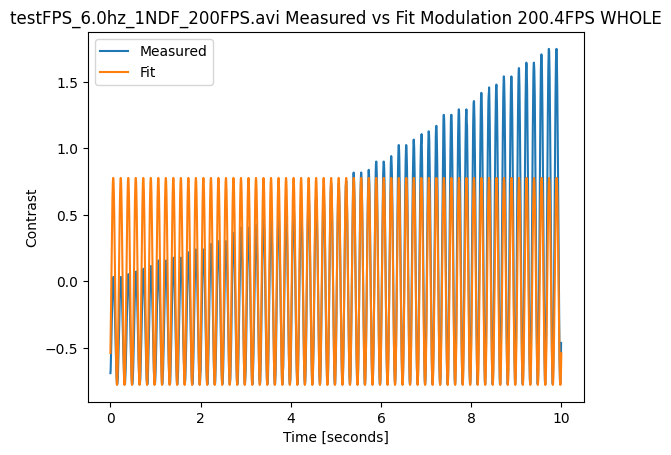

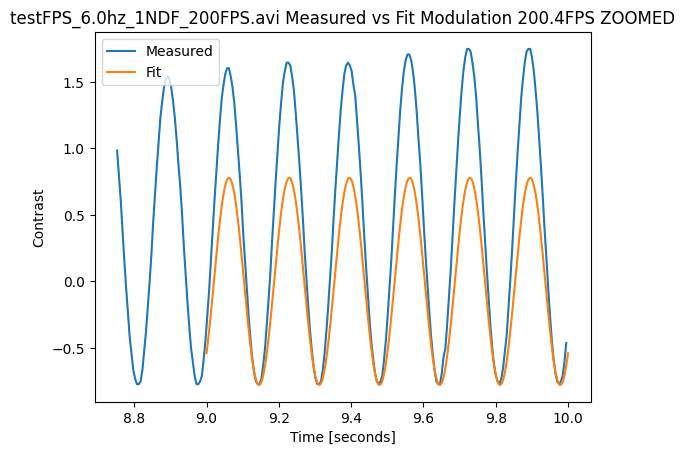

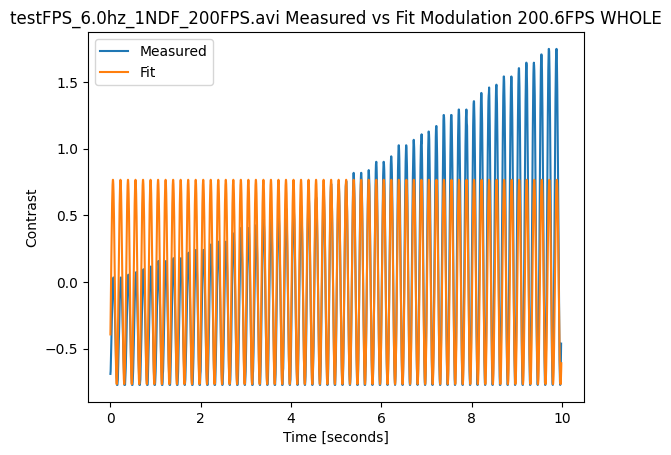

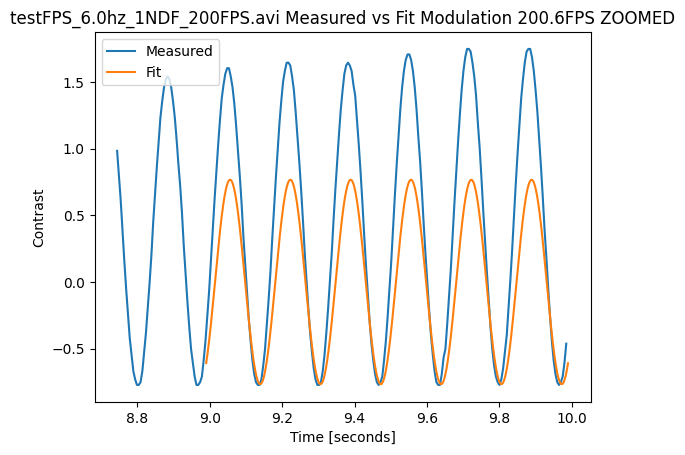

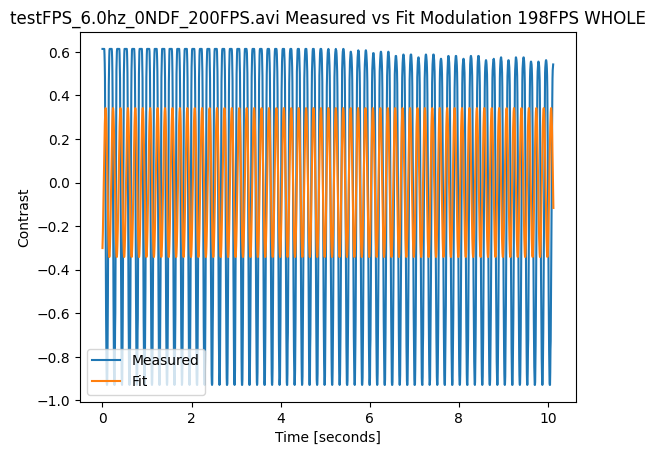

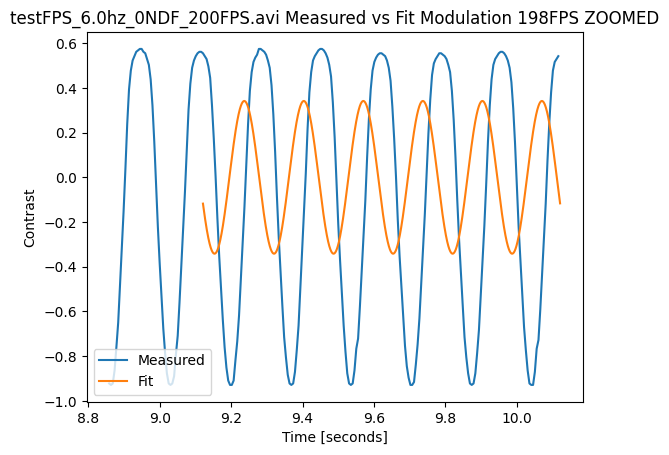

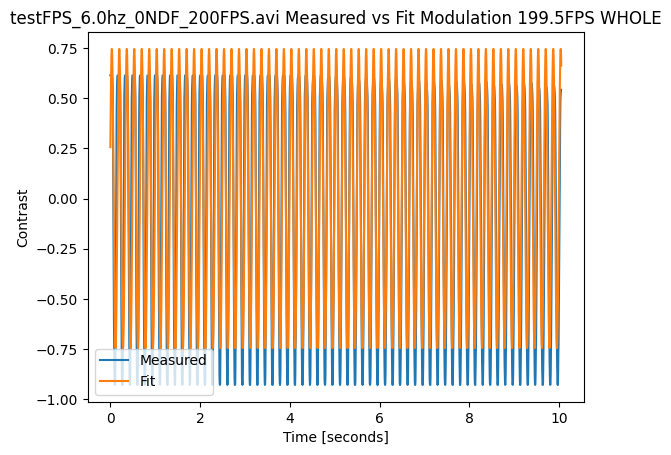

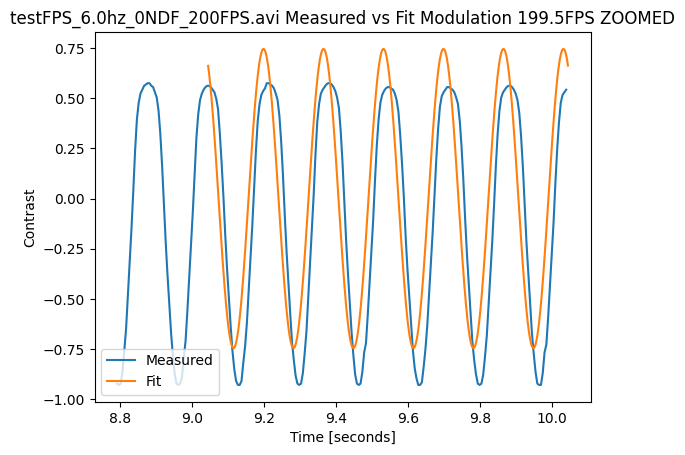

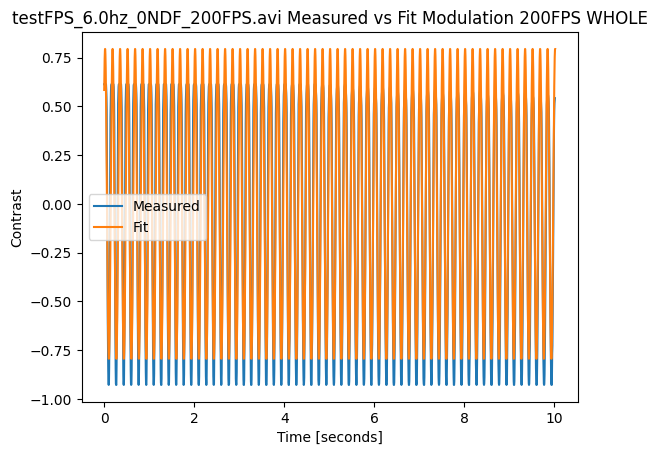

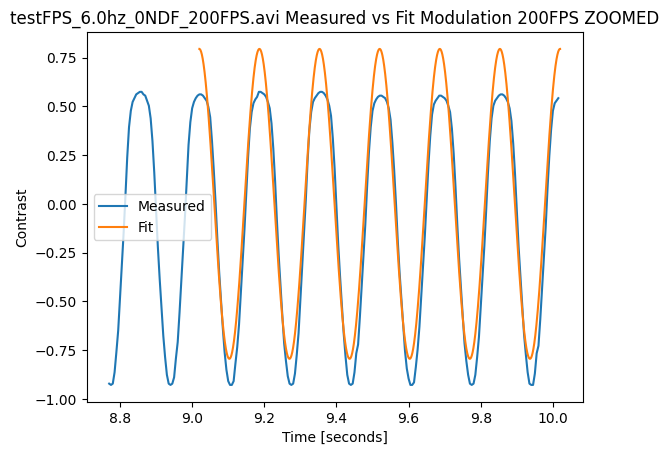

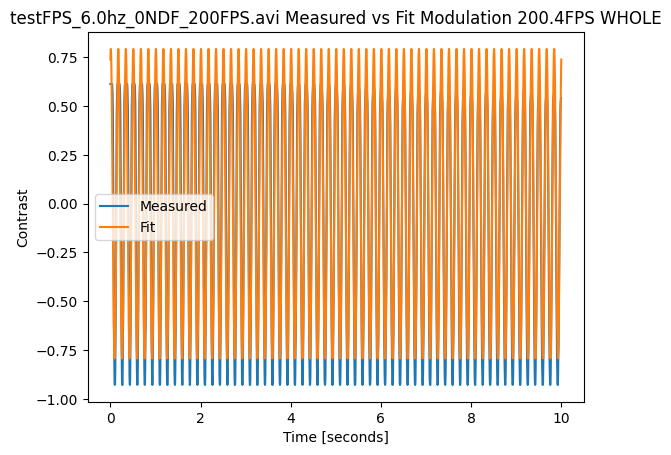

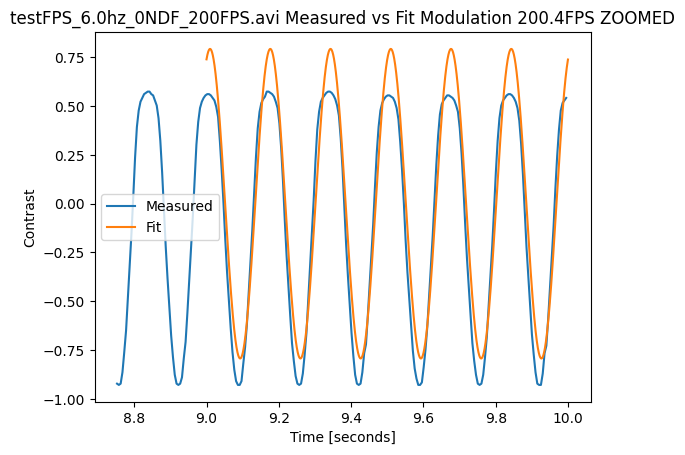

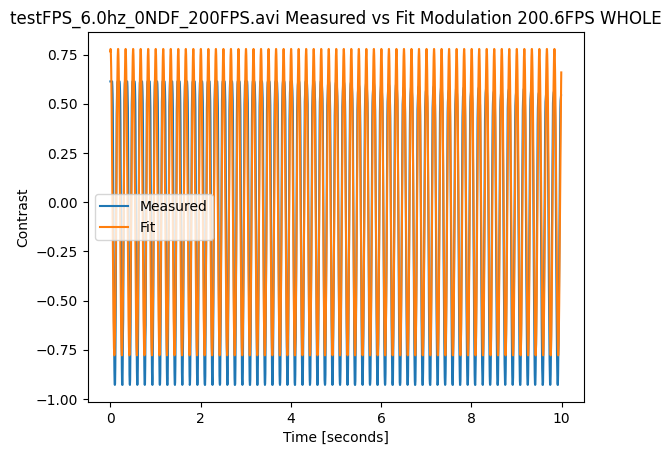

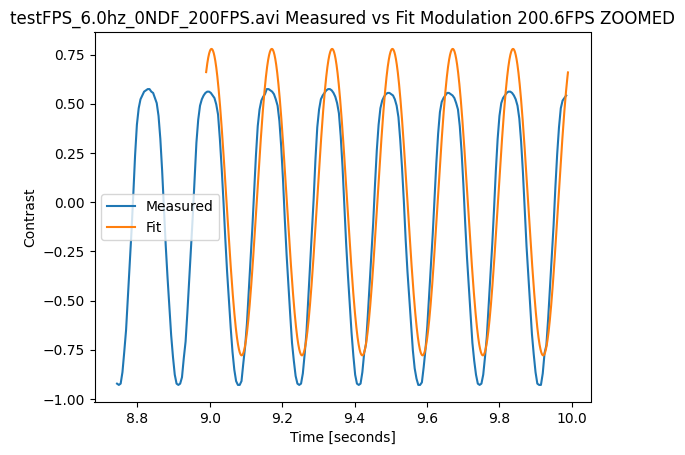

In [11]:
for i, (video_name, video_data) in enumerate(zip(findings_df['video_name'], data_table)):
    for j, fps in enumerate((200, 200.4)):
        observed_signal_T, signal, observed_model_T, observed_fit = video_data[j]


        plt.plot(observed_signal_T, signal, linestyle='-', label="Measured")
        plt.plot(observed_model_T, observed_fit, linestyle='-', label="Fit")
        plt.legend()
        plt.title(f"{os.path.basename(video_name)} Measured vs Fit Modulation {fps}FPS WHOLE")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Contrast')

        plt.show()


        plt.plot(observed_signal_T[-250:], signal[-250:], linestyle='-', label="Measured")
        plt.plot(observed_model_T[-10000:], observed_fit[-10000:], linestyle='-', label="Fit")
        plt.legend()
        plt.title(f"{os.path.basename(video_name)} Measured vs Fit Modulation {fps}FPS ZOOMED")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Contrast')
        

        plt.show()






In [ ]:
eng.quit()